In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.abspath("../../"))
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from src.config import Config
from src.rag import ChromaSlideStore
import pandas as pd

from src.eval.evaluate import EvaluationConfig, RAGEvaluatorLangsmith
from src.config import load_spreadsheet

from langchain.callbacks import tracing_v2_enabled

config = Config()

In [3]:
# Enable LangSmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "default"

In [4]:
from src.rag.score import (
    ExponentialScorer, HyperbolicScorer, MinScorer,
    ExponentialWeightedScorer, HyperbolicWeightedScorer
)
from src.eval.evaluate import (
    page_found, page_match, presentation_found,
    presentation_match, create_llm_relevance_evaluator,
    n_pages, n_pres
)


# Initialize components
embeddings = config.embedding_config.load_vsegpt()
storage = ChromaSlideStore(collection_name="pres1", embedding_model=embeddings)


# Load questions if needed
sheet_id = os.environ["BENCHMARK_SPREADSHEET_ID"]
df_questions = RAGEvaluatorLangsmith.load_questions_from_sheet(sheet_id)
print("N_questions:", len(df_questions))
df_questions.sample(5)

N_questions: 67


,pres_name,question,page,content,comment,MinScorer,Hyperbolic Scorer
42,3.AutoFE-сапер_Валерия Дымбицкая_вер.3,На слайде был ядерный гриб,43,visual,NaN,NaN,NaN
21,4.Эволюция отбора кандидатов в системе товарны...,Презентация про маркетплейсы,,general,NaN,FAIL,FAIL
18,1.За рамками сценария_Эмели Драль_вер.3,В какой презентации обсуждали методы оценки LLM,38,general,NaN,PASS,PASS
49,1.Разметка датасетов в эпоху мультимодальности...,Где обсуждали датасет с жестами?,20,visual,NaN,NaN,NaN
23,SP_Навигатор_по_мерам_гос_поддержки_2024_74_стр,Презентация в которой рассматривались субсидии...,23,text,NaN,PASS,PASS


In [6]:
dataset_name = "PresRetrieve_25"
df_eval = df_questions
scorers = [MinScorer(), ExponentialScorer(), HyperbolicScorer(), ExponentialWeightedScorer(), HyperbolicWeightedScorer()]
# scorers = [HyperbolicWeightedScorer()]

# dataset_name = "PresRetrieve_5"
# df_eval = df_questions.sample(5)
# scorers = [MinScorer(), HyperbolicScorer() ]

llm = Config().model_config.load_vsegpt(model="openai/gpt-4o-mini", temperature=0.1)

eval_config = EvaluationConfig(
    dataset_name=dataset_name,
    evaluators=[
        presentation_match,
        page_match,
        presentation_found,
        page_found,
        # create_llm_relevance_evaluator(llm),
        n_pages,
        n_pres
    ],
    scorers=scorers,
    max_concurrency=1
)

evaluator = RAGEvaluatorLangsmith(storage=storage, config=eval_config, llm=llm)
evaluator.create_or_load_dataset(df_eval)
# evaluator.create_dataset(dataset_name+"test", df_eval)


Using existing dataset: PresRetrieve_25


Dataset(name='PresRetrieve_25', description=None, data_type=<DataType.kv: 'kv'>, id=UUID('e25f48e1-fd33-4a9d-aca2-d19232ad1a34'), created_at=datetime.datetime(2024, 12, 6, 10, 0, 7, 865953, tzinfo=datetime.timezone.utc), modified_at=datetime.datetime(2024, 12, 6, 10, 0, 7, 865953, tzinfo=datetime.timezone.utc), example_count=25, session_count=11, last_session_start_time=datetime.datetime(2024, 12, 9, 15, 43, 21, 176360), inputs_schema=None, outputs_schema=None)

In [ ]:
import nest_asyncio
nest_asyncio.apply()
# Run evaluation
evaluator.run_evaluation()

# Результаты
- Классификатор слишком легко признает выдачу релевантной. Надо модифицировать промпт
- В бенчмарке мало негативных примеров 
  - Я его составляю вопросы на которые точно есть ответ. Поэтому сложнее оценивать, насколько LLM качественно отлавливает неправильную выдачу
  - Мб добавить точно нерелевантные вопросы: 
    - "Презентация про космонавтов" - совсем нет в базе
    - "Презентация про экономику Китая" - есть презентации про экономику, но про Китай - нет
    - "Презентация про обучение LLM на CPU" - есть презентации про обучение LLM, но точно не на CPU

In [12]:
from langsmith.schemas import Example, Run
from IPython.display import display

dataset_name = "PresRetrieve_25"
project_name = "hyperbolicweighted_k2.0_p3.0-aa5bda8e"
client = evaluator.client

resp = client.read_project(project_name=project_name, include_stats=True)

print(resp.json(indent=2))

{
  "id": "1f5f916b-eb71-4f02-aa77-f61f47d73477",
  "start_time": "2024-12-06T10:41:27.210742+00:00",
  "end_time": "2024-12-06T10:42:01.085768+00:00",
  "description": null,
  "name": "hyperbolicweighted_k2.0_p3.0-aa5bda8e",
  "extra": {
    "metadata": {
      "git": {
        "tags": null,
        "dirty": true,
        "branch": "local",
        "commit": "14e06a5b0e8fdef7183134a681161f11151fc5ae",
        "repo_name": "presentation-rag",
        "remote_url": "git@gitlab.raftds.com:ilia.tambovtsev/presentation-rag.git",
        "author_name": "Ilia Tambovtsev",
        "commit_time": "1733223665",
        "author_email": "ilia.tambovtsev@raftds.com"
      },
      "scorer": "hyperbolicweighted_k2.0_p3.0",
      "revision_id": "14e06a5-dirty",
      "dataset_splits": [
        "base"
      ],
      "dataset_version": "2024-12-06T10:00:08.701903+00:00",
      "num_repetitions": 1
    }
  },
  "tenant_id": "44cd8e12-235d-52ea-a8de-1063f25bb9a4",
  "reference_dataset_id": "e25f48e1-fd

In [13]:
projects = list(p.name for p in evaluator.client.list_projects())

In [14]:
runs = client.list_runs(project_name=project_name, execution_order=1)
df = pd.DataFrame([{
    "example_id": r.reference_example_id,
    **r.inputs,
    **(r.outputs or {}),
    **{k: v for f in client.list_feedback(run_ids=[r.id]) for k, v in [(f"{f.key}.score", f.score), (f"{f.key}.comment", f.comment)]},
    "reference": client.read_example(r.reference_example_id).outputs
} for r in runs])

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   example_id                  25 non-null     object 
 1   inputs                      25 non-null     object 
 2   contexts                    25 non-null     object 
 3   n_pres.score                25 non-null     float64
 4   n_pres.comment              25 non-null     object 
 5   n_pages.score               25 non-null     float64
 6   n_pages.comment             25 non-null     object 
 7   llm_relevance.score         25 non-null     float64
 8   llm_relevance.comment       25 non-null     object 
 9   page_found.score            25 non-null     float64
 10  page_found.comment          25 non-null     object 
 11  presentation_found.score    25 non-null     float64
 12  presentation_found.comment  25 non-null     object 
 13  page_match.score            25 non-nu

In [23]:
df["contexts"][0]

[{'pres_name': 'ABN AMRO - Global Economic Forecasts 28 august',
  'pages': [1, 2],
  'contexts': ['Slide 0:\n\n\nText Content:\n\nЗаголовок: "Глобальные экономические прогнозы"\n\nПодзаголовок: "Группа экономики | 28 августа 2024"\n\nОсновные показатели прогноза:\n- ВВП (% годовых)\n- Инфляция (% годовых)\n- Уровень безработицы (%)\n\nТаблица с данными по странам:\n1. США\n2. Еврозона\n3. Германия\n4. Франция\n5. Нидерланды\n6. Великобритания\n7. Япония\n\nСноска: "Источник: LSEG, EIU, ABN AMRO Group Economics" \n\nСтилизация текста: заголовок выделен крупным шрифтом, подзаголовок - меньшим, таблицы имеют четкие границы и выделение для ключевых данных.\n\n\nVisual Content:\n\nНа слайде представлена таблица с прогнозами по ключевым экономическим показателям для различных стран. Таблица разделена на несколько секций:\n1. Прогнозы ключевых индикаторов\n2. Текущий счет (% от ВВП)\n3. Бюджетный баланс (% от ВВП)\n4. Государственный долг (% от ВВП)\n\nКаждая секция содержит строки с названи

In [19]:
runs = list(client.list_runs(project_name=project_name, execution_order=1))
r = runs[0]
r.outputs
# client.read_example(r.reference_example_id).outputs
# client.read_example(runs)

{'contexts': [{'pres_name': 'ABN AMRO - Global Economic Forecasts 28 august',
   'pages': [1, 2],
   'contexts': ['Slide 0:\n\n\nText Content:\n\nЗаголовок: "Глобальные экономические прогнозы"\n\nПодзаголовок: "Группа экономики | 28 августа 2024"\n\nОсновные показатели прогноза:\n- ВВП (% годовых)\n- Инфляция (% годовых)\n- Уровень безработицы (%)\n\nТаблица с данными по странам:\n1. США\n2. Еврозона\n3. Германия\n4. Франция\n5. Нидерланды\n6. Великобритания\n7. Япония\n\nСноска: "Источник: LSEG, EIU, ABN AMRO Group Economics" \n\nСтилизация текста: заголовок выделен крупным шрифтом, подзаголовок - меньшим, таблицы имеют четкие границы и выделение для ключевых данных.\n\n\nVisual Content:\n\nНа слайде представлена таблица с прогнозами по ключевым экономическим показателям для различных стран. Таблица разделена на несколько секций:\n1. Прогнозы ключевых индикаторов\n2. Текущий счет (% от ВВП)\n3. Бюджетный баланс (% от ВВП)\n4. Государственный долг (% от ВВП)\n\nКаждая секция содержит с

In [49]:
from src.config.output_formatting import format_dict_output
from src.config.output_formatting import MultilineWrapper
text_wrapper = MultilineWrapper(width=100)

def print_eval_row(row):
    contexts = row["contexts"]
    input = row["inputs"]["question"]

    print(f"Input: {input}")
    contexts_info = [c["pres_name"] for c in contexts]
    print(f"Contexts: {len(contexts)}\n", format_dict_output(dict(contexts = contexts_info)))
    print(f"LLM answer: {row['llm_relevance.score']}\n", text_wrapper.fill(row["llm_relevance.comment"]))

In [ ]:
false_relevant = (
    df.query("`llm_relevance.score` == 1.0 and `presentation_match.score` == 0.0")
)
display(false_relevant)

for _, row in false_relevant.iterrows():
    print_eval_row(row)
    print("-" * 50)

,example_id,inputs,contexts,n_pres.score,n_pres.comment,n_pages.score,n_pages.comment,llm_relevance.score,llm_relevance.comment,page_found.score,page_found.comment,presentation_found.score,presentation_found.comment,page_match.score,page_match.comment,presentation_match.score,presentation_match.comment,reference
0,19b01bc1-bcec-4533-981d-a4d5aae002b3,{'question': 'В какой презентации был график с...,[{'pres_name': 'ABN AMRO - Global Economic For...,9.0,,2.0,,1.0,Both slides contain relevant information regar...,1.0,,1.0,,1.0,,0.0,,"{'pages': [5], 'pres_name': 'ЯиП_Энергетически..."
20,b62930e4-8ec7-4101-9207-ee5d882d42ac,{'question': 'Презентация в которой был мем с ...,[{'pres_name': '2. Пристягина Матрицы компетен...,10.0,,8.0,,1.0,The slide descriptions contain references to h...,0.0,,1.0,,0.0,,0.0,,"{'pages': [-1], 'pres_name': '4.Эволюция отбор..."
21,9fc34dca-00d7-4ec9-8c0f-062e47cddf54,{'question': 'Презентация про маркетплейсы'},[{'pres_name': 'dodo-brands-monthly-trading-up...,13.0,,5.0,,1.0,The slide descriptions provide insights into t...,0.0,,1.0,,0.0,,0.0,,"{'pages': [-1], 'pres_name': '4.Эволюция отбор..."


Input: В какой презентации был график с экономическими событиями?
Contexts: 9
 Contexts:
    ['ABN AMRO - Global Economic Forecasts 28 august', 
    'ЯиП_Энергетический_переход_Вызовы_и_возможности_для_России', 
    'SP_Навигатор_по_мерам_гос_поддержки_2024_74_стр', 'Kept_Подвижной 
    состав РФ_2024 (20 стр)', '3. Тенденции рынка труда 2024', 
    'dodo-brands-monthly-trading-update-sep-2024', '1.За рамками 
    сценария_Эмели Драль_вер.3', '4.Эволюция отбора кандидатов в системе 
    товарных рекомендаций Ozon_Александр Краснов_вер.3', '3.Система 
    управления процессом окомкования железорудных окатышей_Андрей 
    Голов_вер.2']
LLM answer: 1.0
 Both slides contain relevant information regarding economic indicators, including GDP, inflation, 
and other economic metrics. The presence of tables with economic data suggests that they likely 
include graphs or visual representations of these trends, which aligns with the user's query about a
 presentation featuring a graph of economic 

Ответ 1: На top-1 слайде есть таблица с экономическими событиями. LLM так и сказала "The presence of tables with economic data suggests that they likely include graphs or visual representations of these trends"

Ответ 2: "Сказал, что раз есть смешная картинка, то наверное это про Вовочку." 

Ответ 3: "Слайд про продажи, значит и про маркетплейсы"

In [41]:
false_irrelevant = (
    df.query("`llm_relevance.score` == 0.0 and `presentation_match.score` == 1.0")
)
display(false_irrelevant)

,example_id,inputs,contexts,n_pres.score,n_pres.comment,n_pages.score,n_pages.comment,llm_relevance.score,llm_relevance.comment,page_found.score,page_found.comment,presentation_found.score,presentation_found.comment,page_match.score,page_match.comment,presentation_match.score,presentation_match.comment,reference


## True Negatives
Модель только один раз распознала неправильную выдачу

In [48]:
true_irrelevant = (
    df.query("`llm_relevance.score` == 0.0 and `presentation_match.score` == 0.0")
)
display(true_irrelevant)
for _, row in true_irrelevant.iterrows():
    print_eval_row(row)
    print("-" * 50)

,example_id,inputs,contexts,n_pres.score,n_pres.comment,n_pages.score,n_pages.comment,llm_relevance.score,llm_relevance.comment,page_found.score,page_found.comment,presentation_found.score,presentation_found.comment,page_match.score,page_match.comment,presentation_match.score,presentation_match.comment,reference
11,536d91c7-10c9-4bbf-8b0b-71fab114d5d0,{'question': 'Слайд с Трампом'},[{'pres_name': '2. Пристягина Матрицы компетен...,11.0,,5.0,,0.0,Neither slide descriptions contain any relevan...,0.0,,1.0,,0.0,,0.0,,"{'pages': [15], 'pres_name': '4.Обзор уязвимос..."


Input: Слайд с Трампом
Contexts: 11
 Contexts:
    ['2. Пристягина Матрицы компетенций', 'Accenture x UN_GenAI For 
    Global Goals_2024 (39 pgs)', 
    'SP_Навигатор_по_мерам_гос_поддержки_2024_74_стр', '2.Kolmogorov 
    Arnold Networks_Павел Плюснин_вер.2', '4.Обзор уязвимостей и техник 
    защиты для LLM_Евгений Кокуйкин_вер.3', '3.Система управления 
    процессом окомкования железорудных окатышей_Андрей Голов_вер.2', 
    '4.Эволюция отбора кандидатов в системе товарных рекомендаций 
    Ozon_Александр Краснов_вер.3', 'Kept_Подвижной состав РФ_2024 (20 
    стр)', '1.За рамками сценария_Эмели Драль_вер.3', '3. Тенденции рынка 
    труда 2024', 
    'ЯиП_Энергетический_переход_Вызовы_и_возможности_для_России']
LLM answer: 0.0
 Neither slide descriptions contain any relevant information related to the query about a slide 
featuring Trump. The first slide discusses a competency matrix and features a character resembling 
Yoda, while the second slide introduces an employee named I

In [54]:
true_relevant = (
    df.query("`llm_relevance.score` == 1.0 and `presentation_match.score` == 1.0")
)
display(len(true_relevant))

21

## Confusion Matrix

Text(50.722222222222214, 0.5, 'Actual')

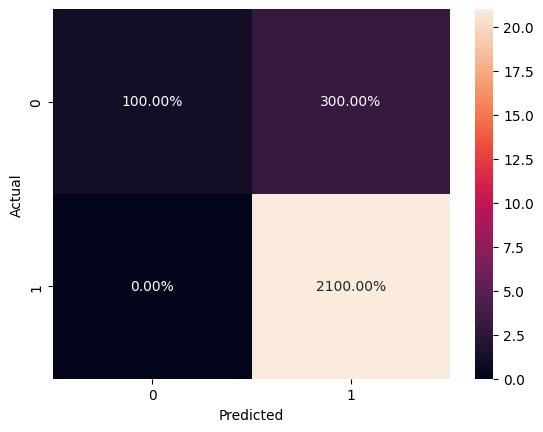

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt

y_true = df["presentation_match.score"]
y_pred = df["llm_relevance.score"]
conf_mat =  confusion_matrix(y_true, y_pred)

tn, fp, fn, tp = conf_mat.ravel()
sns.heatmap(conf_mat, annot=True, fmt='.2%', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

Precision:0.875
Recall: 1.0


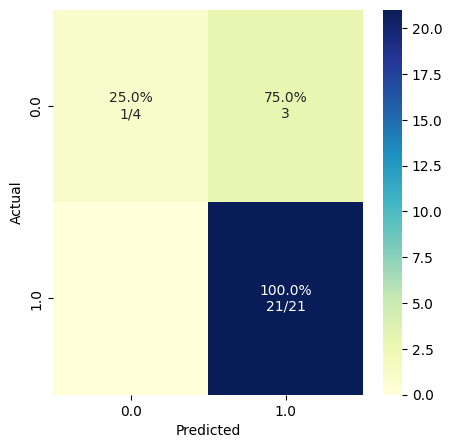

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i][0]
                annot[i, j] = f"{p:.1f}%\n{c}/{s}"
            elif c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = f"{p:.1f}%\n{c}"
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = "Actual"
    cm.columns.name = "Predicted"
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt="", ax=ax)

plot_cm(y_true, y_pred)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f"Precision:{precision}")
print(f"Recall: {recall}")